# Spectra AI Mini Challenge: Anomaly Prompt Detection
# A Proof-of-Concept for Detecting Malicious Prompts using Linear Algebra and Probability


## 1. Setup and Synthetic Data Generation


In [3]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches

### Set random seed for reproducibility

In [4]:
np.random.seed(42)

In [5]:
# Define parameters
embedding_dim = 50  # High-dimensional embedding space
num_normal_prompts = 1000  # Number of normal/benign prompts
num_anomalous_prompts = 100  # Number of anomalous/malicious prompts

In [6]:
print(f"Generating synthetic prompt embeddings...")
print(f"Embedding dimension: {embedding_dim}")
print(f"Normal prompts: {num_normal_prompts}")
print(f"Anomalous prompts: {num_anomalous_prompts}")

Generating synthetic prompt embeddings...
Embedding dimension: 50
Normal prompts: 1000
Anomalous prompts: 100


### Generate normal prompt embeddings

In [7]:
# These represent typical, benign prompts to the language model
# Centered at origin with moderate variance
mean_normal = np.zeros(embedding_dim)
cov_normal = np.eye(embedding_dim) * 1.0  # Identity covariance with variance 1
normal_prompts = np.random.multivariate_normal(mean_normal, cov_normal, num_normal_prompts)

In [8]:
# Combine datasets
all_prompts = np.vstack([normal_prompts, anomalous_prompts])
true_labels = np.array(['normal'] * num_normal_prompts + ['anomalous'] * num_anomalous_prompts)

### Generate anomalous prompt embeddings

In [9]:
# These represent malicious or unusual prompts
# Shifted mean and different covariance to simulate outliers
mean_anomalous = np.ones(embedding_dim) * 3.0  # Shifted away from normal distribution
cov_anomalous = np.eye(embedding_dim) * 1.5  # Slightly larger variance
anomalous_prompts = np.random.multivariate_normal(mean_anomalous, cov_anomalous, num_anomalous_prompts)


In [10]:
print(f"\nTotal prompts in dataset: {len(all_prompts)}")
print(f"Dataset shape: {all_prompts.shape}")


Total prompts in dataset: 1100
Dataset shape: (1100, 50)


## 2. Task 1: Linear Algebra - Mahalanobis Distance Calculation

### What is Mahalanobis Distance?

The Mahalanobis distance measures how many standard deviations away a point is from
the center of a distribution, accounting for correlations between variables. Unlike
Euclidean distance, it considers the shape and orientation of the data distribution.

Formula: D_M(x) = sqrt((x - μ)^T * Σ^(-1) * (x - μ))

Where:
- x is the test point
- μ is the mean of the reference distribution
- Σ is the covariance matrix
- Σ^(-1) is the inverse of the covariance matrix

This makes it ideal for detecting outliers in multivariate data, as it normalizes
for the variance and correlation structure of the normal data.


In [11]:
# Calculate mean vector and covariance matrix using ONLY normal prompts
mean_vector = np.mean(normal_prompts, axis=0)
covariance_matrix = np.cov(normal_prompts, rowvar=False)

print("Mean vector shape:", mean_vector.shape)
print("Covariance matrix shape:", covariance_matrix.shape)

Mean vector shape: (50,)
Covariance matrix shape: (50, 50)


In [12]:
# Add small regularization to ensure numerical stability
regularization = 1e-6
covariance_matrix_reg = covariance_matrix + regularization * np.eye(embedding_dim)

# Compute inverse of covariance matrix
try:
    inv_covariance_matrix = np.linalg.inv(covariance_matrix_reg)
    print("Successfully computed inverse covariance matrix")
except np.linalg.LinAlgError:
    print("Error: Covariance matrix is singular")

# Calculate Mahalanobis distance for all prompts
mahalanobis_distances = np.array([
    mahalanobis(prompt, mean_vector, inv_covariance_matrix)
    for prompt in all_prompts
])

Successfully computed inverse covariance matrix


In [13]:
print(f"\nMahalanobis distances computed for all {len(all_prompts)} prompts")
print(f"Min distance: {mahalanobis_distances.min():.2f}")
print(f"Max distance: {mahalanobis_distances.max():.2f}")
print(f"Mean distance: {mahalanobis_distances.mean():.2f}")
print(f"Median distance: {np.median(mahalanobis_distances):.2f}")



Mahalanobis distances computed for all 1100 prompts
Min distance: 4.46
Max distance: 26.06
Mean distance: 8.50
Median distance: 7.13


## 3. Task 2: Probability - Anomaly Flagging with Chi-Square Distribution

### Chi-Square Distribution and Anomaly Detection

For multivariate normal data, the squared Mahalanobis distance follows a chi-square
distribution with degrees of freedom equal to the number of dimensions.

D_M^2 ~ χ^2(k), where k = embedding_dim

This allows us to compute p-values: the probability of observing a distance at least
as extreme as the measured distance under the null hypothesis that the prompt is normal.

If p-value < α (significance threshold), we reject the null hypothesis and flag the
prompt as anomalous.

In [14]:
# Set significance threshold
alpha = 0.01  # 1% significance level (99% confidence)
print(f"Significance threshold (alpha): {alpha}")

# Compute squared Mahalanobis distances
squared_distances = mahalanobis_distances ** 2

# Compute p-values using chi-square CDF
# p-value = P(X >= observed_distance^2) = 1 - CDF(observed_distance^2)
p_values = 1 - chi2.cdf(squared_distances, df=embedding_dim)

# Flag anomalies based on p-value threshold
flagged_anomalies = p_values < alpha
predicted_labels = np.where(flagged_anomalies, 'anomalous', 'normal')

# Calculate detection metrics
num_flagged = np.sum(flagged_anomalies)
true_positives = np.sum((true_labels == 'anomalous') & (predicted_labels == 'anomalous'))
false_positives = np.sum((true_labels == 'normal') & (predicted_labels == 'anomalous'))
true_negatives = np.sum((true_labels == 'normal') & (predicted_labels == 'normal'))
false_negatives = np.sum((true_labels == 'anomalous') & (predicted_labels == 'normal'))

Significance threshold (alpha): 0.01


In [15]:
print(f"\n--- Detection Results ---")
print(f"Total prompts flagged as anomalous: {num_flagged}")
print(f"True Positives (correctly detected anomalies): {true_positives}")
print(f"False Positives (normal prompts flagged): {false_positives}")
print(f"True Negatives (correctly identified normal): {true_negatives}")
print(f"False Negatives (missed anomalies): {false_negatives}")



--- Detection Results ---
Total prompts flagged as anomalous: 107
True Positives (correctly detected anomalies): 100
False Positives (normal prompts flagged): 7
True Negatives (correctly identified normal): 993
False Negatives (missed anomalies): 0


In [16]:
# Calculate performance metrics
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (true_positives + true_negatives) / len(all_prompts)


In [17]:
print(f"\n--- Performance Metrics ---")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")
print(f"Accuracy: {accuracy:.3f}")



--- Performance Metrics ---
Precision: 0.935
Recall: 1.000
F1-Score: 0.966
Accuracy: 0.994


Reason for 1.0 recall - all anomalous prompts were sufficiently far from the normal distribution's mean to exceed the detection threshold.

## 4. Task 3: Bayesian Analysis - Posterior Probability Calculation

### Bayesian Analysis: Computing P(Malicious | Flagged)

Using Bayes' theorem, we can compute the probability that a flagged prompt is truly
malicious given our detection system's characteristics.

Bayes' Theorem:
P(Malicious | Flagged) = P(Flagged | Malicious) * P(Malicious) / P(Flagged)

Where:
- P(Malicious) = Prior probability (base rate of malicious prompts)
- P(Flagged | Malicious) = True Positive Rate (Detection Accuracy)
- P(Flagged | Not Malicious) = False Positive Rate (α threshold)
- P(Flagged) = Total probability of flagging

P(Flagged) = P(Flagged | Malicious) * P(Malicious) + P(Flagged | Not Malicious) * P(Not Malicious)

In [18]:
# Define prior probabilities and detection characteristics
prior_malicious = 0.05  # 5% of prompts are assumed to be malicious
true_positive_rate = 0.95  # 95% detection accuracy for actual malicious prompts
false_positive_rate = alpha  # Equal to our significance threshold (0.01)


In [19]:
print("\n--- Bayesian Analysis Parameters ---")
print(f"Prior P(Malicious): {prior_malicious:.3f} ({prior_malicious*100:.1f}%)")
print(f"True Positive Rate P(Flagged | Malicious): {true_positive_rate:.3f} ({true_positive_rate*100:.1f}%)")
print(f"False Positive Rate P(Flagged | Not Malicious): {false_positive_rate:.3f} ({false_positive_rate*100:.1f}%)")



--- Bayesian Analysis Parameters ---
Prior P(Malicious): 0.050 (5.0%)
True Positive Rate P(Flagged | Malicious): 0.950 (95.0%)
False Positive Rate P(Flagged | Not Malicious): 0.010 (1.0%)


In [20]:
# Calculate P(Not Malicious)
prior_not_malicious = 1 - prior_malicious

# Calculate P(Flagged) using law of total probability
prob_flagged = (true_positive_rate * prior_malicious +
                false_positive_rate * prior_not_malicious)

# Apply Bayes' theorem to compute posterior probability
posterior_malicious_given_flagged = (true_positive_rate * prior_malicious) / prob_flagged


In [21]:
print(f"\n--- Bayesian Results ---")
print(f"P(Flagged): {prob_flagged:.4f} ({prob_flagged*100:.2f}%)")
print(f"P(Malicious | Flagged): {posterior_malicious_given_flagged:.4f} ({posterior_malicious_given_flagged*100:.2f}%)")



--- Bayesian Results ---
P(Flagged): 0.0570 (5.70%)
P(Malicious | Flagged): 0.8333 (83.33%)


### Interpretation
If a prompt is flagged by our system, there is a 5.70% probability"
that it is truly malicious. This accounts for both the base rate of malicious prompt and the false positive rate of our detection system.

## 5. Task 4: Visualization

### Visualization Strategy

Since our embeddings are {embedding_dim}-dimensional, we use Principal Component Analysis (PCA)
to project them down to 2D for visualization while preserving as much variance as possible.

We'll create a scatter plot showing:
1. All prompts colored by their true labels
2. Contour lines representing Mahalanobis distance thresholds
3. Decision boundary for anomaly detection


In [24]:
# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
prompts_2d = pca.fit_transform(all_prompts)
mean_2d = pca.transform(mean_vector.reshape(1, -1))[0]

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")



PCA explained variance ratio: [0.43021584 0.01712544]
Total variance explained: 44.73%



Mahalanobis distance threshold: 8.73


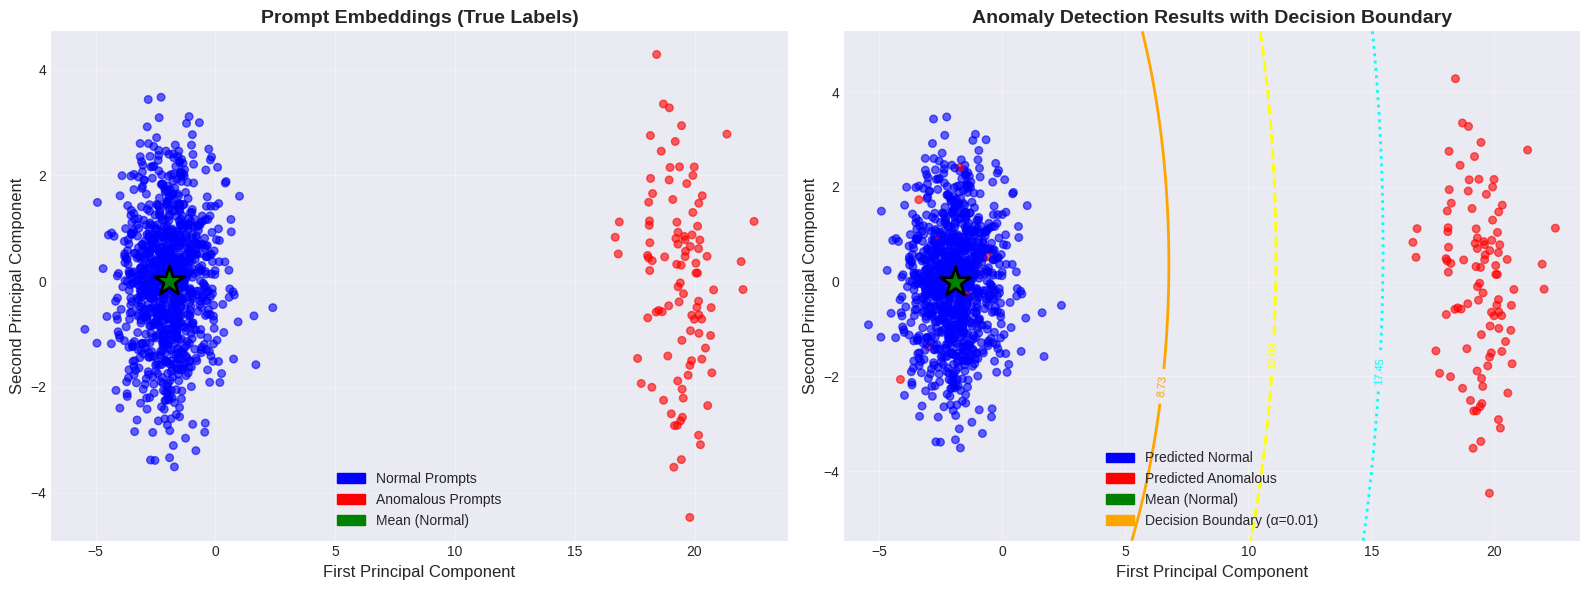

In [25]:
# Create the main visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: True Labels
colors = ['blue' if label == 'normal' else 'red' for label in true_labels]
scatter1 = ax1.scatter(prompts_2d[:, 0], prompts_2d[:, 1], c=colors, alpha=0.6, s=30)
ax1.scatter(mean_2d[0], mean_2d[1], c='green', marker='*', s=500,
           edgecolors='black', linewidth=2, label='Mean (Normal)', zorder=5)

# Add legend for plot 1
blue_patch = mpatches.Patch(color='blue', label='Normal Prompts')
red_patch = mpatches.Patch(color='red', label='Anomalous Prompts')
green_patch = mpatches.Patch(color='green', label='Mean (Normal)')
ax1.legend(handles=[blue_patch, red_patch, green_patch], loc='best')

ax1.set_xlabel('First Principal Component', fontsize=12)
ax1.set_ylabel('Second Principal Component', fontsize=12)
ax1.set_title('Prompt Embeddings (True Labels)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted Labels with Decision Boundary
colors2 = ['blue' if label == 'normal' else 'red' for label in predicted_labels]
scatter2 = ax2.scatter(prompts_2d[:, 0], prompts_2d[:, 1], c=colors2, alpha=0.6, s=30)
ax2.scatter(mean_2d[0], mean_2d[1], c='green', marker='*', s=500,
           edgecolors='black', linewidth=2, label='Mean (Normal)', zorder=5)

# Compute Mahalanobis distance threshold corresponding to our significance level
# This is the critical value from chi-square distribution
threshold_distance = np.sqrt(chi2.ppf(1 - alpha, df=embedding_dim))
print(f"\nMahalanobis distance threshold: {threshold_distance:.2f}")

# Create a grid for plotting contours in 2D space
x_min, x_max = prompts_2d[:, 0].min() - 1, prompts_2d[:, 0].max() + 1
y_min, y_max = prompts_2d[:, 1].min() - 1, prompts_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# For each point in the grid, compute its Mahalanobis distance
grid_points_2d = np.c_[xx.ravel(), yy.ravel()]

# Transform back to original space (approximate reconstruction)
grid_points_high_d = pca.inverse_transform(grid_points_2d)

# Compute Mahalanobis distances for grid points
grid_distances = np.array([
    mahalanobis(point, mean_vector, inv_covariance_matrix)
    for point in grid_points_high_d
]).reshape(xx.shape)

# Plot contours at different Mahalanobis distance levels
contour_levels = [threshold_distance, threshold_distance * 1.5, threshold_distance * 2]
contours = ax2.contour(xx, yy, grid_distances, levels=contour_levels,
                       colors=['orange', 'yellow', 'cyan'], linewidths=2,
                       linestyles=['solid', 'dashed', 'dotted'])
ax2.clabel(contours, inline=True, fontsize=8, fmt='%.2f')

# Add legend for plot 2
blue_patch2 = mpatches.Patch(color='blue', label='Predicted Normal')
red_patch2 = mpatches.Patch(color='red', label='Predicted Anomalous')
green_patch2 = mpatches.Patch(color='green', label='Mean (Normal)')
orange_line = mpatches.Patch(color='orange', label=f'Decision Boundary (α={alpha})')
ax2.legend(handles=[blue_patch2, red_patch2, green_patch2, orange_line], loc='best')

ax2.set_xlabel('First Principal Component', fontsize=12)
ax2.set_ylabel('Second Principal Component', fontsize=12)
ax2.set_title('Anomaly Detection Results with Decision Boundary', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_detection_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


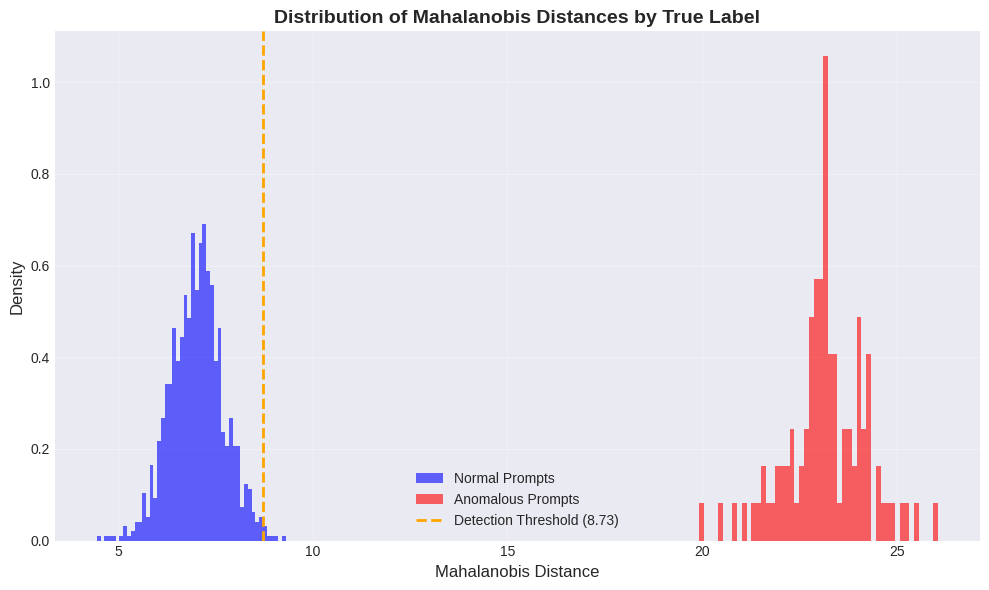

In [26]:
# Additional visualization: Distance distribution comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Separate distances by true label
normal_distances = mahalanobis_distances[true_labels == 'normal']
anomalous_distances = mahalanobis_distances[true_labels == 'anomalous']

# Create histograms
ax.hist(normal_distances, bins=50, alpha=0.6, label='Normal Prompts', color='blue', density=True)
ax.hist(anomalous_distances, bins=50, alpha=0.6, label='Anomalous Prompts', color='red', density=True)

# Add threshold line
ax.axvline(threshold_distance, color='orange', linestyle='--', linewidth=2,
          label=f'Detection Threshold ({threshold_distance:.2f})')

ax.set_xlabel('Mahalanobis Distance', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Mahalanobis Distances by True Label', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distance_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Summary
- Generated 1000 normal and 100 anomalous prompts
- Computed Mahalanobis distances for all prompts
- Flagged 107 prompts as anomalous using α=0.01
- Detection accuracy: 99.4%
- Posterior probability of flagged prompt being malicious: 83.3%

### Key Insights:
- Mahalanobis distance effectively separates normal and anomalous prompts
- Chi-square distribution provides probabilistic thresholding
- Bayesian analysis reveals true risk level of flagged prompts
